In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline
df = pd.read_csv('./data-labled/songs-femal-male-lable.csv')
print(df.head())

   Unnamed: 0                                             Lyrics  Year  \
0           0  sam the sham miscellaneous wooly bully wooly b...  1965   
1          10   trailer for sale or rent rooms to let fifty c...  1965   
2          11  let me tell ya bout the birds and the bees and...  1965   
3          12   hold me hold me never let me go until youve t...  1965   
4          13  i said Ì¢shotgun shoot em for he runs now do t...  1965   

  dominant_gender  
0          female  
1            male  
2          female  
3          female  
4            male  


In [2]:
df['dominant_gender'].value_counts()

female    1267
male       592
Name: dominant_gender, dtype: int64

In [3]:
group = df.groupby("dominant_gender")
df_male = group.get_group('male')

print(len(df_male))
frames = [df_male, df]
df = pd.concat(frames, axis=0)
df['dominant_gender'].value_counts()

592


female    1267
male      1184
Name: dominant_gender, dtype: int64

In [4]:
# transverting categories into numerical data

df['category_id'] = df['dominant_gender'].factorize()[0]
category_id_df = df[['dominant_gender', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'dominant_gender']].values)

print(df.head(3))

   Unnamed: 0                                             Lyrics  Year  \
1          10   trailer for sale or rent rooms to let fifty c...  1965   
4          13  i said Ì¢shotgun shoot em for he runs now do t...  1965   
9          20   slaycrewetook a walk and passed your house la...  1965   

  dominant_gender  category_id  
1            male            0  
4            male            0  
9            male            0  


In [5]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',  lowercase=True, ngram_range=(3, 4), stop_words='english')
features = tfidf.fit_transform(df.Lyrics.values.astype('U')).toarray()
labels = df.category_id
features.shape

#find the terms which are most correlated by each gender
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2
# for dominant_gender, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(dominant_gender))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
#   print("\n")

(2451, 494)

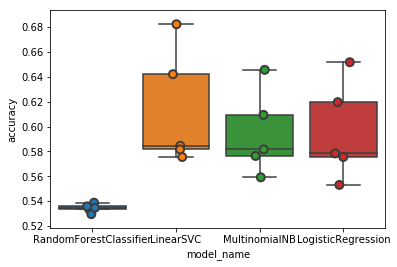

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

cv_df.groupby('model_name').accuracy.mean()

plt.show()

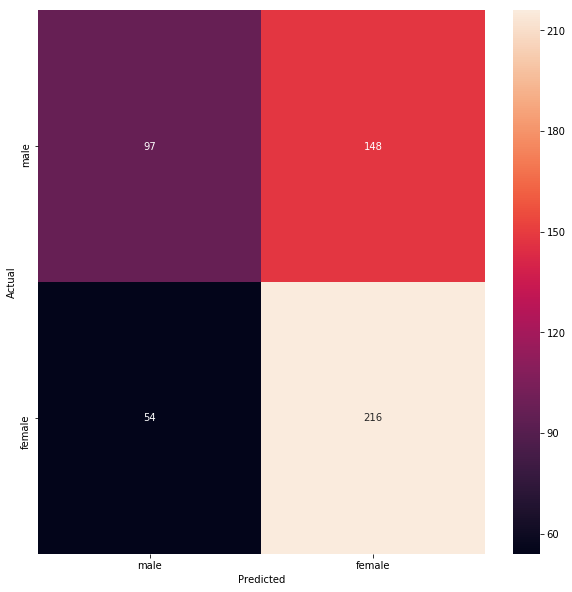

In [7]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.21, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.dominant_gender.values, yticklabels=category_id_df.dominant_gender.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# y_pred = tfidf.tranform("this is an example")
# model.predict(y_pred)

In [8]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['dominant_gender', 'Lyrics']])
      print('')

'female' predicted as 'male' : 54 examples.


,dominant_gender,Lyrics
1800,female,hey wheres the drumooh girl youre shining like...
324,female,marie marie la voodoo veau shell put a spell o...
431,female,im in love with the girl that im talking about...
1514,female,youve been waiting so long im here to answer y...
176,female,its your thing do what you wanna do i cant te...
1619,female,shawtys like a melody in my head that i cant ...
1393,female,memories are just where you laid them drag th...
1188,female,wish id told her how i felt then maybe shed be...
1674,female,i heard that youre settled down that you foun...
226,female,give me just a little more time and our love w...



'male' predicted as 'female' : 148 examples.


,dominant_gender,Lyrics
419,male,spirit move me every time im near you whirlin...
419,male,spirit move me every time im near you whirlin...
1112,male,break it down againso those are my dreams and...
1112,male,break it down againso those are my dreams and...
112,male,the hombres miscellaneous let it out let it al...
112,male,the hombres miscellaneous let it out let it al...
207,male,war huh yeah what is it good for absolutely n...
207,male,war huh yeah what is it good for absolutely n...
765,male,we started dancing and love put us into a gro...
765,male,we started dancing and love put us into a gro...


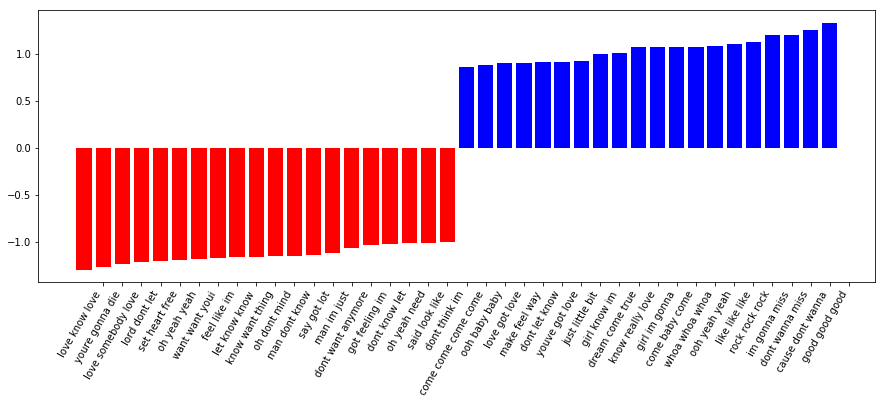

In [9]:

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

plot_coefficients(model, tfidf.get_feature_names())


In [10]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['dominant_gender'].unique()))

             precision    recall  f1-score   support

       male       0.64      0.40      0.49       245
     female       0.59      0.80      0.68       270

avg / total       0.62      0.61      0.59       515



In [ ]:
with open("model.pkl","wb") as fout:
    pickle.dump(model,fout)
    
with open("tfidf.pkl","wb") as fout:
    pickle.dump(tfidf,fout)